# OBJETIVO DO ESTUDO
## Checar se a nota média e a receita de um filme podem ser explicadas/preditas atraves de um modelo de regressão linear simples/múltipla

## Importando Bibliotecas

In [61]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
import sqlite3
import statsmodels.api as sm
from statsmodels.stats.diagnostic import het_breuschpagan, lilliefors
from statsmodels.stats.outliers_influence import variance_inflation_factor



## Carregando o Dataset

Carregando dataset "movies" do arquivo movies.db

In [126]:
conn = sqlite3.connect('movies.db')
df = pd.read_sql_query("SELECT * FROM movies WHERE revenue > 0 AND budget >0  ", conn)
conn.close()
df.head(10)
print("Checando o tipo dos dados")
print(df.dtypes)
print("Checando se há dados nulos")
print(df.isnull().sum())
print("Checando se há dados zerados")
print(df.shape)
print((df == 0).sum())

Checando o tipo dos dados
id                int64
title               str
release_date        str
runtime           int64
budget            int64
revenue           int64
vote_average    float64
popularity      float64
vote_count        int64
dtype: object
Checando se há dados nulos
id              0
title           0
release_date    0
runtime         0
budget          0
revenue         0
vote_average    0
popularity      0
vote_count      0
dtype: int64
Checando se há dados zerados
(1035, 9)
id              0
title           0
release_date    0
runtime         0
budget          0
revenue         0
vote_average    2
popularity      0
vote_count      2
dtype: int64


In [127]:
numeric_cols = df.select_dtypes(include='number')
# Convertendo para base logarítmica devido a escala.
numeric_cols['log_budget'] = np.log1p(numeric_cols['budget'])
numeric_cols['log_revenue'] = np.log1p(numeric_cols['revenue'])
numeric_cols.drop(columns=["id","budget","revenue"], inplace=True)
numeric_cols.describe()

,runtime,vote_average,popularity,vote_count,log_budget,log_revenue
count,1035.000000,1035.000000,1035.000000,1035.000000,1035.000000,1035.000000
mean,118.285024,7.006323,13.078067,6971.466667,17.204021,18.152931
std,24.044143,0.870575,19.196733,6837.762373,1.663368,2.350729
min,3.000000,0.000000,6.851500,0.000000,1.609438,1.791759
25%,101.000000,6.518000,7.747600,1230.500000,16.380460,17.069746
50%,115.000000,7.057000,9.179900,5153.000000,17.453097,18.762623
75%,131.000000,7.597500,12.060400,10562.000000,18.420681,19.832376
max,229.000000,10.000000,370.855000,38779.000000,20.185240,21.796118


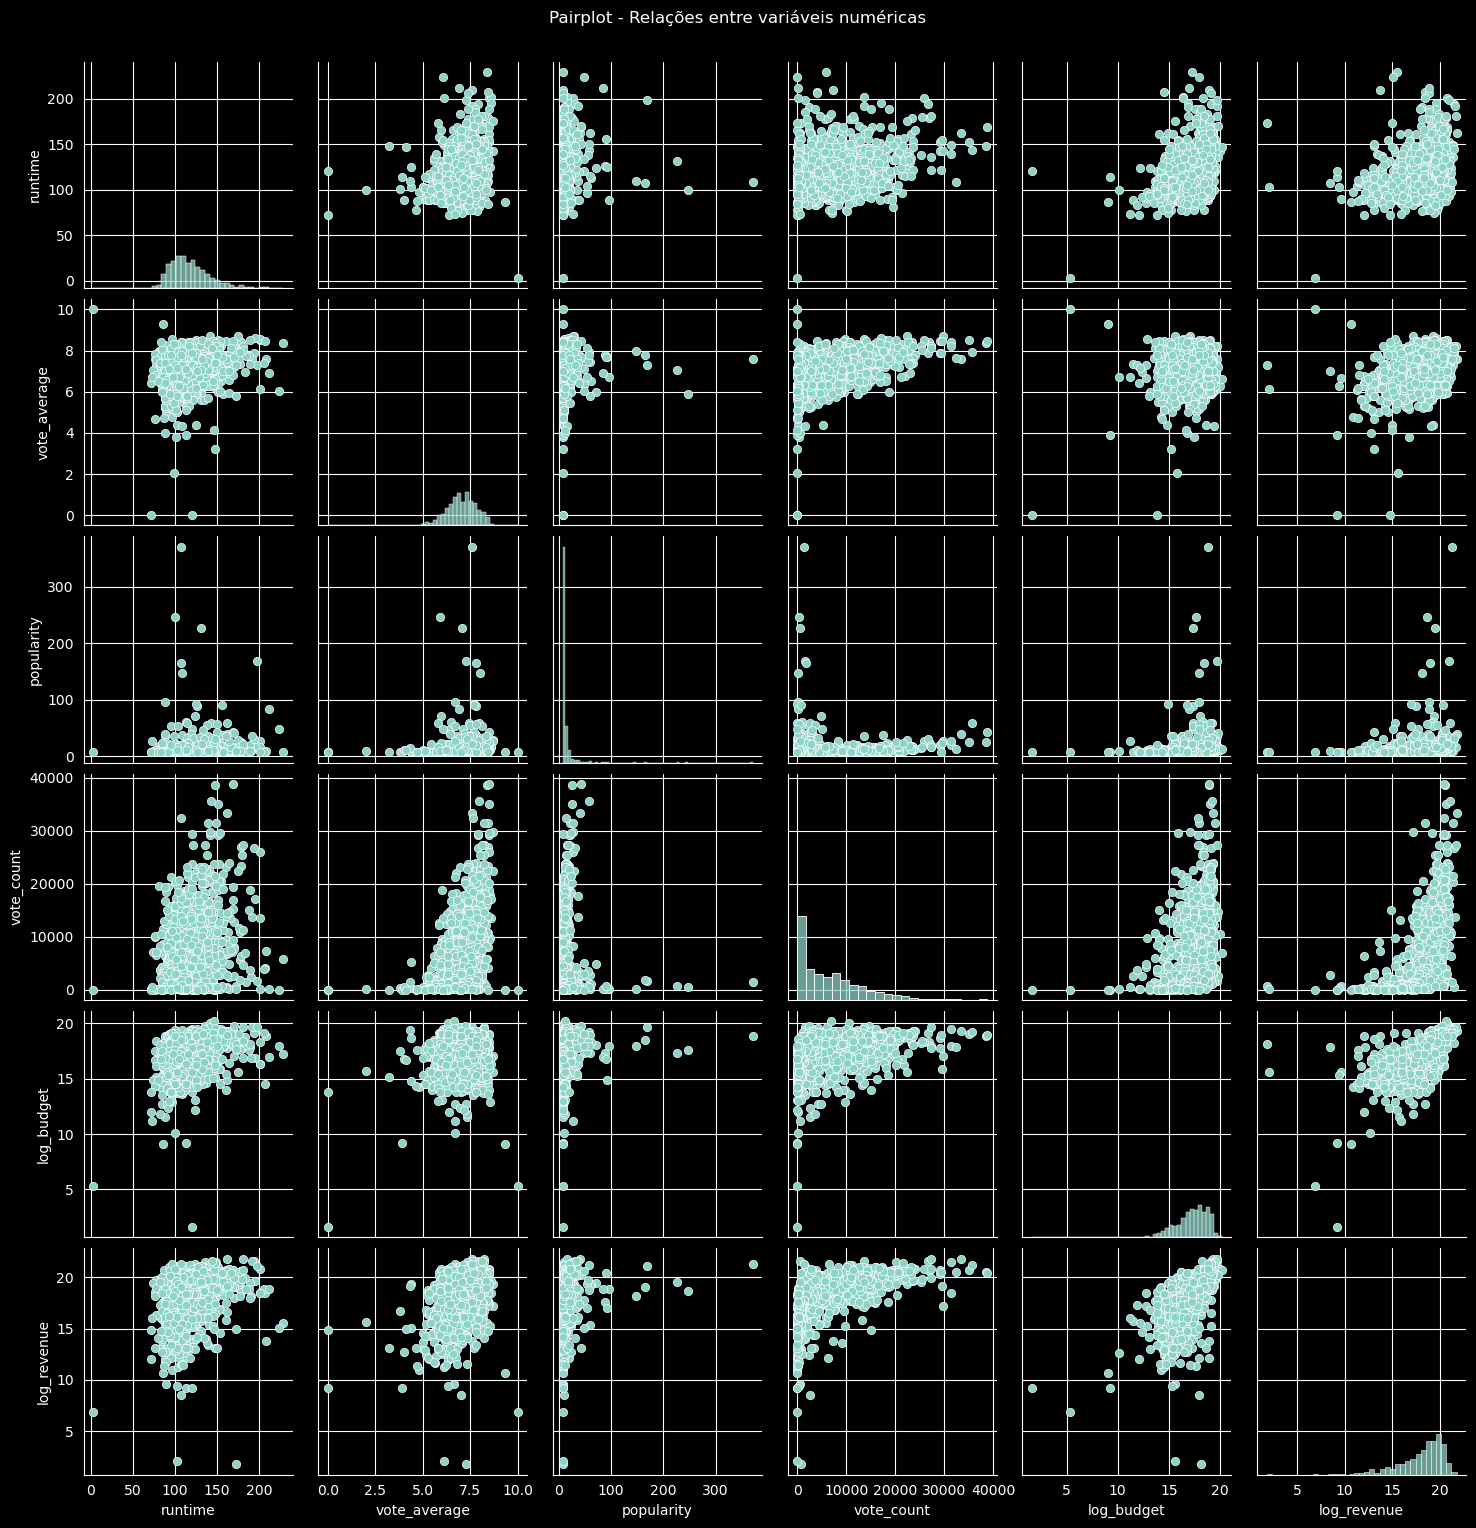

In [128]:
sns.pairplot(numeric_cols)
plt.suptitle("Pairplot - Relações entre variáveis numéricas", y=1.02)
plt.show()

## Teste de normalidade (Shapiro-Wilk)

In [129]:
for col in numeric_cols:
    stat,p = stats.shapiro(numeric_cols[col])
    print(f"{col}: stat={stat:.4f}, p={p:.4f}")

runtime: stat=0.9419, p=0.0000
vote_average: stat=0.9211, p=0.0000
popularity: stat=0.2494, p=0.0000
vote_count: stat=0.8723, p=0.0000
log_budget: stat=0.8884, p=0.0000
log_revenue: stat=0.8766, p=0.0000


Com o valor de p<0.05 podemos rejeitar a hipótese nula (os dados não são normalmente distribuidos)

## Cálculo da correlação

Aplicando a correlação de spearman para detectar correlações moderadas/fortes entre os dados quantitativos

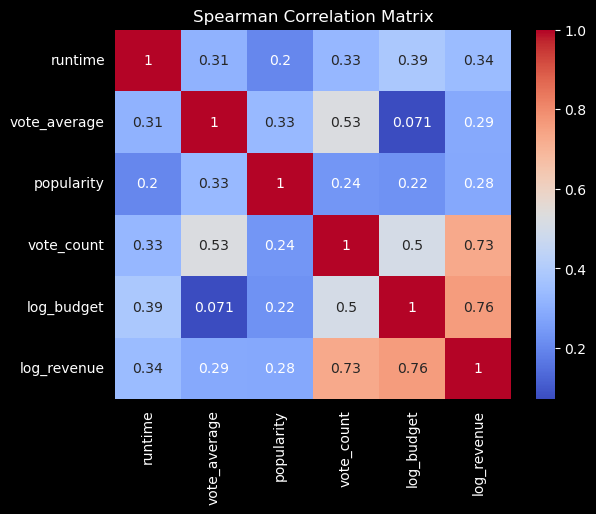

In [130]:
corr_spearman = numeric_cols.corr(method='spearman')
sns.heatmap(corr_spearman,annot=True, cmap='coolwarm')
plt.title('Spearman Correlation Matrix')
plt.show()

In [131]:
def list_significant_correlations():
    mask  = np.triu( np.ones_like(corr_spearman, dtype=bool) )
    #print(np.shape(corr_spearman.mask(mask).unstack()) )
    df = corr_spearman.mask(mask).unstack().dropna()
    filter = df[abs(df) >=0.5]
    tuple_list_corr = [ (index, round(value,4)) for index, value in filter.items()]
    tuple_list_corr = sorted(tuple_list_corr, key=lambda x: x[1], reverse=True)
    print("Lista de correlações fortes/moderadas")
    for par,value in tuple_list_corr:
        print(f"{par[0]} e {par[1]} : {value}")

list_significant_correlations()

Lista de correlações fortes/moderadas
log_budget e log_revenue : 0.7633
vote_count e log_revenue : 0.7313
vote_average e vote_count : 0.5282
vote_count e log_budget : 0.5041


In [132]:
print("\nTeste de Hipótese - Correlação entre revenue e budget")
r,p_value = stats.spearmanr(numeric_cols['log_revenue'], numeric_cols['log_budget'])
print(f"r = {r:.4f} / p = {p_value:.4f}")
print("\nTeste de Hipótese - Correlação entre revenue e vote_average")
r,p_value = stats.spearmanr(numeric_cols['log_revenue'], numeric_cols['vote_average'])
print(f"r = {r:.4f} / p = {p_value:.4f}")
print("\nTeste de Hipótese - Correlação entre revenue e runtime")
r,p_value = stats.spearmanr(numeric_cols['log_revenue'], numeric_cols['runtime'])
print(f"r = {r:.4f} / p = {p_value:.4f}")



Teste de Hipótese - Correlação entre revenue e budget
r = 0.7633 / p = 0.0000

Teste de Hipótese - Correlação entre revenue e vote_average
r = 0.2851 / p = 0.0000

Teste de Hipótese - Correlação entre revenue e runtime
r = 0.3429 / p = 0.0000


Os testes de hipótese (Correlação de Spearman) indicam que todas as variáveis testadas possuem uma relação estatisticamente significativa com a receita, dado que todos os p-valores foram inferiores a $0,05$ ($p = 0,0000$), permitindo rejeitar a hipótese nula de ausência de relação. No entanto, a intensidade dessa relação varia significativamente: o **budget** apresenta uma correlação forte ($r = 0,76$), enquanto o **vote_average** e o **runtime** possuem correlações positivas, porém fracas.

## Modelo de regressão

In [133]:
#Variaveis independentes
X_budget = numeric_cols['log_budget']
X_vote_average = numeric_cols['vote_average']
X_runtime = numeric_cols['runtime']

#Variável dependente
y= numeric_cols['log_revenue']

# Adicionando uma constante à variável independente
X_budget = sm.add_constant(X_budget)
X_vote_average = sm.add_constant(X_vote_average)
X_runtime = sm.add_constant(X_runtime)

# Ajustando o modelo de regressão linear
budget_model = sm.OLS(y, X_budget).fit()
vote_average_model = sm.OLS(y, X_vote_average).fit()
runtime_model = sm.OLS(y, X_runtime).fit()

# Sumário do modelo
budget_model_summary = budget_model.summary()
vote_average_model_summary = vote_average_model.summary()
runtime_model_summary = runtime_model.summary()

print("***Budget model summary:***\n\n", budget_model_summary)

print("\n\n\n***Vote average model summary:***\n\n",vote_average_model_summary)

print("***\n\n\nRuntime model summary:***\n\n",runtime_model_summary)


***Budget model summary:***

                             OLS Regression Results                            
Dep. Variable:            log_revenue   R-squared:                       0.455
Model:                            OLS   Adj. R-squared:                  0.454
Method:                 Least Squares   F-statistic:                     861.4
Date:                Wed, 04 Feb 2026   Prob (F-statistic):          3.42e-138
Time:                        16:49:54   Log-Likelihood:                -2038.9
No. Observations:                1035   AIC:                             4082.
Df Residuals:                    1033   BIC:                             4092.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.7579 

A análise dos modelos de regressão linear simples revela que, embora todos os preditores testados possuam significância estatística — com a probabilidade da estatística F e os p-valores dos coeficientes inferiores a 0,05  —, eles diferem drasticamente em sua capacidade preditiva. O modelo baseado no orçamento (budget_model) destaca-se como o mais robusto,
 apesar de explicar apenas 45,5% da variabilidade da receita ($R^2 = 0,455$). Em contrapartida, os modelos de avaliação do público ($R^2 = 0,115$) e duração ($R^2 = 0,083$), apesar de apresentarem relações reais, explicam uma parcela muito pequena do sucesso financeiro.

## Análise de resíduos - Conformidade com as premissas da Regressão Linear

### Testando a Homocedasticidade dos resíduos

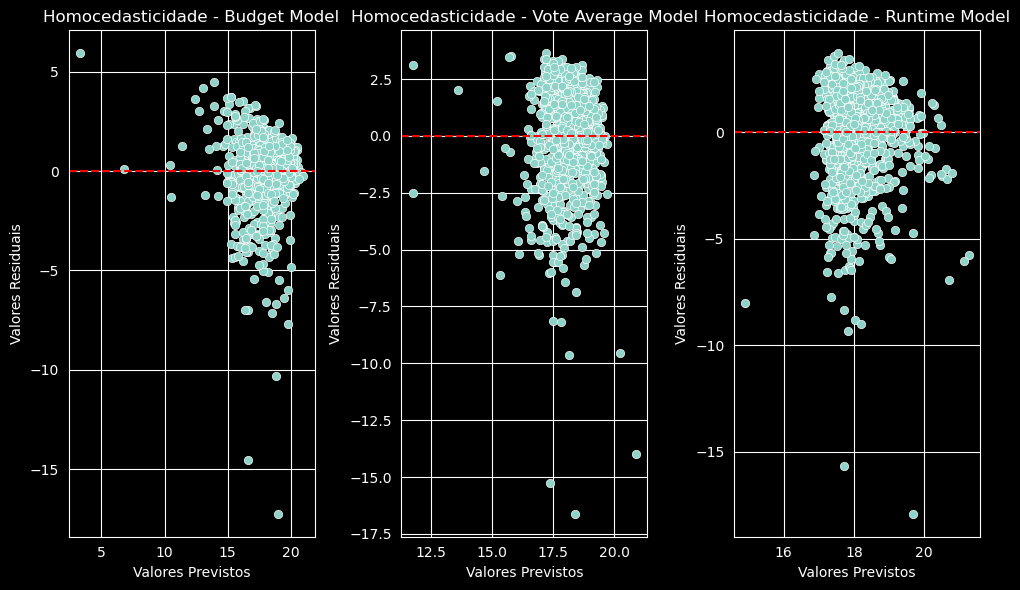

In [134]:
#Resíduos
budget_residuals = budget_model.resid
vote_average_residuals = vote_average_model.resid
runtime_residuals = runtime_model.resid


# Gráfico de homocedasticidade
plt.figure(figsize=(10,6))

plt.subplot(1,3,1)
sns.scatterplot(x=budget_model.fittedvalues,y=budget_residuals)
plt.axhline(y=0,color='red', linestyle='--')
plt.title('Homocedasticidade - Budget Model')
plt.xlabel("Valores Previstos")
plt.ylabel("Valores Residuais")

plt.subplot(1,3,2)
sns.scatterplot(x=vote_average_model.fittedvalues, y=vote_average_residuals)
plt.axhline(y=0,color='red', linestyle='--')
plt.title('Homocedasticidade - Vote Average Model')
plt.xlabel("Valores Previstos")
plt.ylabel("Valores Residuais")

plt.subplot(1,3,3)
sns.scatterplot(x=runtime_model.fittedvalues, y=runtime_residuals)
plt.axhline(y=0, color='red', linestyle='--')
plt.title('Homocedasticidade - Runtime Model')
plt.xlabel("Valores Previstos")
plt.ylabel("Valores Residuais")


plt.tight_layout()
plt.show()

#### **Teste de Homocedasticidade com Breusch-Pagan**

**Hipótese Nula** ($H_0$): Os resíduos são Homocedásticos (a variância é constante).

**Hipótese Alternativa** ($H_a$): Os resíduos são Heterocedásticos (a variância muda conforme o valor da variável independente)

* Se o **p-valor for menor que 0.05**, podemos descartar a hiṕótese nula, ou seja, os resíduos seriam **heterocedásticos**

In [135]:
models = [
    ("budget_model", budget_model, X_budget ),
    ("vote_average_model", vote_average_model, X_vote_average),
    ("runtime_model", runtime_model, X_runtime),
]

for name, model, data in models:
    _, p_value, _, fp_value = het_breuschpagan(model.resid, model.model.exog)
    print(f"Estatísticas para o {name}\n")
    print(f"p-value = {p_value:.4f}")
    print(f"f-value = {fp_value:.4f}")

Estatísticas para o budget_model

p-value = 0.0007
f-value = 0.0007
Estatísticas para o vote_average_model

p-value = 0.1834
f-value = 0.1837
Estatísticas para o runtime_model

p-value = 0.3598
f-value = 0.3603



Após a análise dos gráficos e da realização do teste de Breusch-Pagan, pode-se concluir que há heterocedasticidade no budget_model, violando uma das premissas da Regressão Linear, porém tanto o vote_average_model e o runtime_model apresentam homocedasticidade.

### Testando a normalidade dos resíduos

#### Teste de Shapiro-Wilk

**Hipótese Nula** ($H_0$): Os resíduos segue uma distribuição normal.

**Hipótese Alternativa** ($H_a$): Os resíduos não seguem uma distribuição normal

* Se o **p-valor for menor que 0.05**, podemos descartar a hiṕótese nula, ou seja, os resíduos não seguiriam uma **distribuição normal**

In [139]:
for name, model, data in models:
    _, p_value_shapiro = stats.shapiro(model.resid)
    print(f"Estásticas para o {name}")
    print(f"p-value = {p_value_shapiro:.4f}\n")

Estásticas para o budget_model
p-value = 0.0000

Estásticas para o vote_average_model
p-value = 0.0000

Estásticas para o runtime_model
p-value = 0.0000



##### **Análise gráfica**

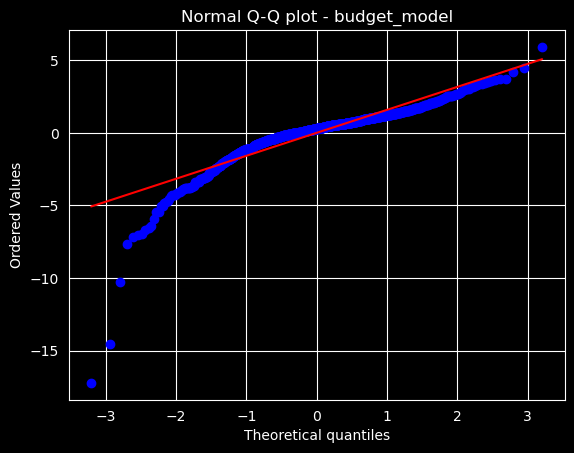

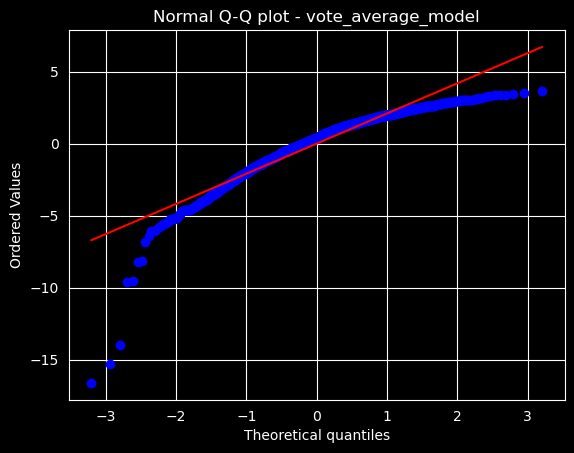

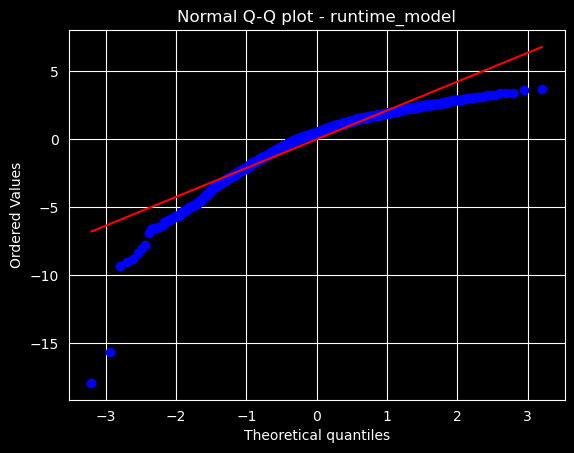

In [144]:
for name, model, data in models:
    stats.probplot(model.resid, dist='norm', plot=plt)
    plt.title(f"Normal Q-Q plot - {name}")
    plt.show()

Feita a análise da normalidade de resíduos, podemos concluir que **eles não seguem uma distribuição normal**, o que contraria uma das premissas da Regressão Linear